In [59]:
import pandas as pd
import numpy as np

In [60]:
train = pd.read_csv("data_train.csv")

In [61]:
seed = 123456

In [62]:
from sklearn.model_selection import StratifiedKFold
sp = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

In [63]:
from imblearn.over_sampling import RandomOverSampler
ous = RandomOverSampler(random_state=seed)

In [64]:
import hyperopt
from hyperopt import hp

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [66]:
def objective(params):
    aucs = []
    for train_index,vali_index in sp.split(train,train['type']):
        data_train = train.iloc[train_index,:]
        data_vali = train.iloc[vali_index,:]
        X_train = data_train.iloc[:,1:-1]
        y_train = data_train.iloc[:,-1]
        X_vali = data_vali.iloc[:,1:-1]
        y_vali = data_vali.iloc[:,-1]
        X_train,y_train = ous.fit_resample(X_train,y_train)
        model = KNeighborsClassifier(n_neighbors=params['n_neighbors'])
        model.fit(X_train,y_train)
        pro_vali = model.predict_proba(X_vali)[:,1]
        auc = roc_auc_score(y_vali,pro_vali)
        aucs.append(auc)
    mean_auc = np.mean(aucs)
    return -mean_auc

In [67]:
space = {
    'n_neighbors':hp.choice('n_neighbors',range(3,500))
}

In [68]:
best_params = hyperopt.fmin(objective, space, algo=hyperopt.tpe.suggest, max_evals=50)

100%|██████████| 50/50 [01:03<00:00,  1.27s/trial, best loss: -0.8228835300555908]


In [69]:
best_params

{'n_neighbors': 165}

In [70]:
from sklearn.metrics import roc_curve

In [71]:
tprs_train = []
tprs_vali = []
fprs = np.linspace(0,1,100)
aucs_train = []
aucs_vali = []
th_tpr = []
th_fpr = []
th_th = []
for train_index,vali_index in sp.split(train,train['type']):
    data_train = train.iloc[train_index,:]
    data_vali = train.iloc[vali_index,:]
    X_train = data_train.iloc[:,1:-1]
    y_train = data_train.iloc[:,-1]
    X_vali = data_vali.iloc[:,1:-1]
    y_vali = data_vali.iloc[:,-1]
    X_train,y_train = ous.fit_resample(X_train,y_train)
    model = KNeighborsClassifier(n_neighbors=166)
    model.fit(X_train,y_train)
    pro_train = model.predict_proba(X_train)[:,1]
    pro_vali = model.predict_proba(X_vali)[:,1]
    fpr_train,tpr_train,th_train = roc_curve(y_train,pro_train)
    fpr_vali,tpr_vali,th_vali = roc_curve(y_vali,pro_vali)
    tprs_train.append(np.interp(fprs,fpr_train,tpr_train))
    tprs_vali.append(np.interp(fprs,fpr_vali,tpr_vali))
    auc_train = roc_auc_score(y_train,pro_train)
    auc_vali = roc_auc_score(y_vali,pro_vali)
    aucs_train.append(auc_train)
    aucs_vali.append(auc_vali)

    th_fpr.append(fpr_vali)
    th_tpr.append(tpr_vali)
    th_th.append(th_vali)

In [72]:
for i in range(len(tprs_train)):
    tprs_train[i][0] = 0
    tprs_vali[i][0] = 0

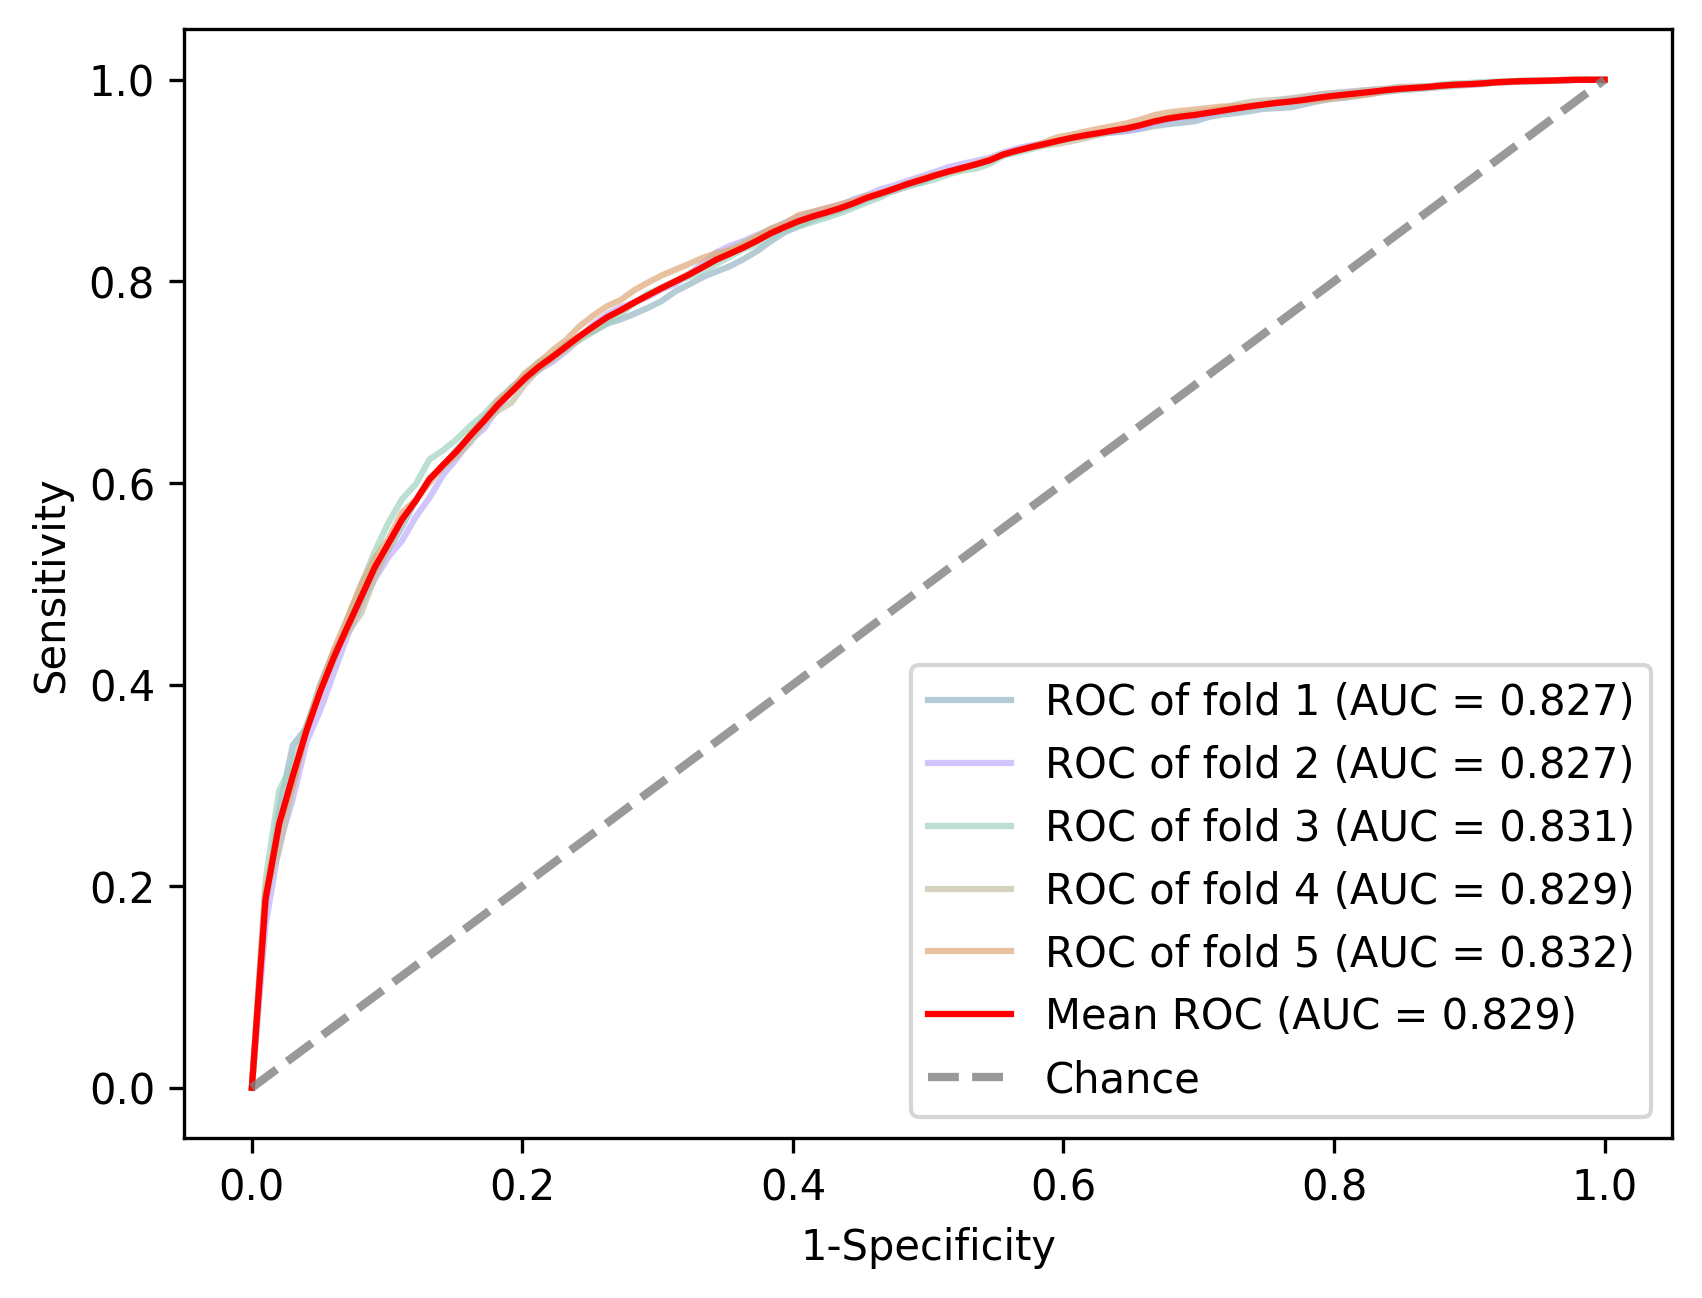

In [73]:
plt.figure(dpi=300)
plt.plot(fprs,tprs_train[0],color='#96B6C5',alpha=0.7,label='ROC of fold 1 (AUC = {:.3f})'.format(aucs_train[0]))
plt.plot(fprs,tprs_train[1],color='#BEADFA',alpha=0.7,label='ROC of fold 2 (AUC = {:.3f})'.format(aucs_train[1]))
plt.plot(fprs,tprs_train[2],color='#9ED2BE',alpha=0.7,label='ROC of fold 3 (AUC = {:.3f})'.format(aucs_train[2]))
plt.plot(fprs,tprs_train[3],color='#C4C1A4',alpha=0.7,label='ROC of fold 4 (AUC = {:.3f})'.format(aucs_train[3]))
plt.plot(fprs,tprs_train[4],color='#DFA878',alpha=0.7,label='ROC of fold 5 (AUC = {:.3f})'.format(aucs_train[4]))
plt.plot(fprs,np.average(tprs_train,axis=0),color='red',label='Mean ROC (AUC = {:.3f})'.format(np.mean(aucs_train)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',label='Chance', alpha=.8)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend()

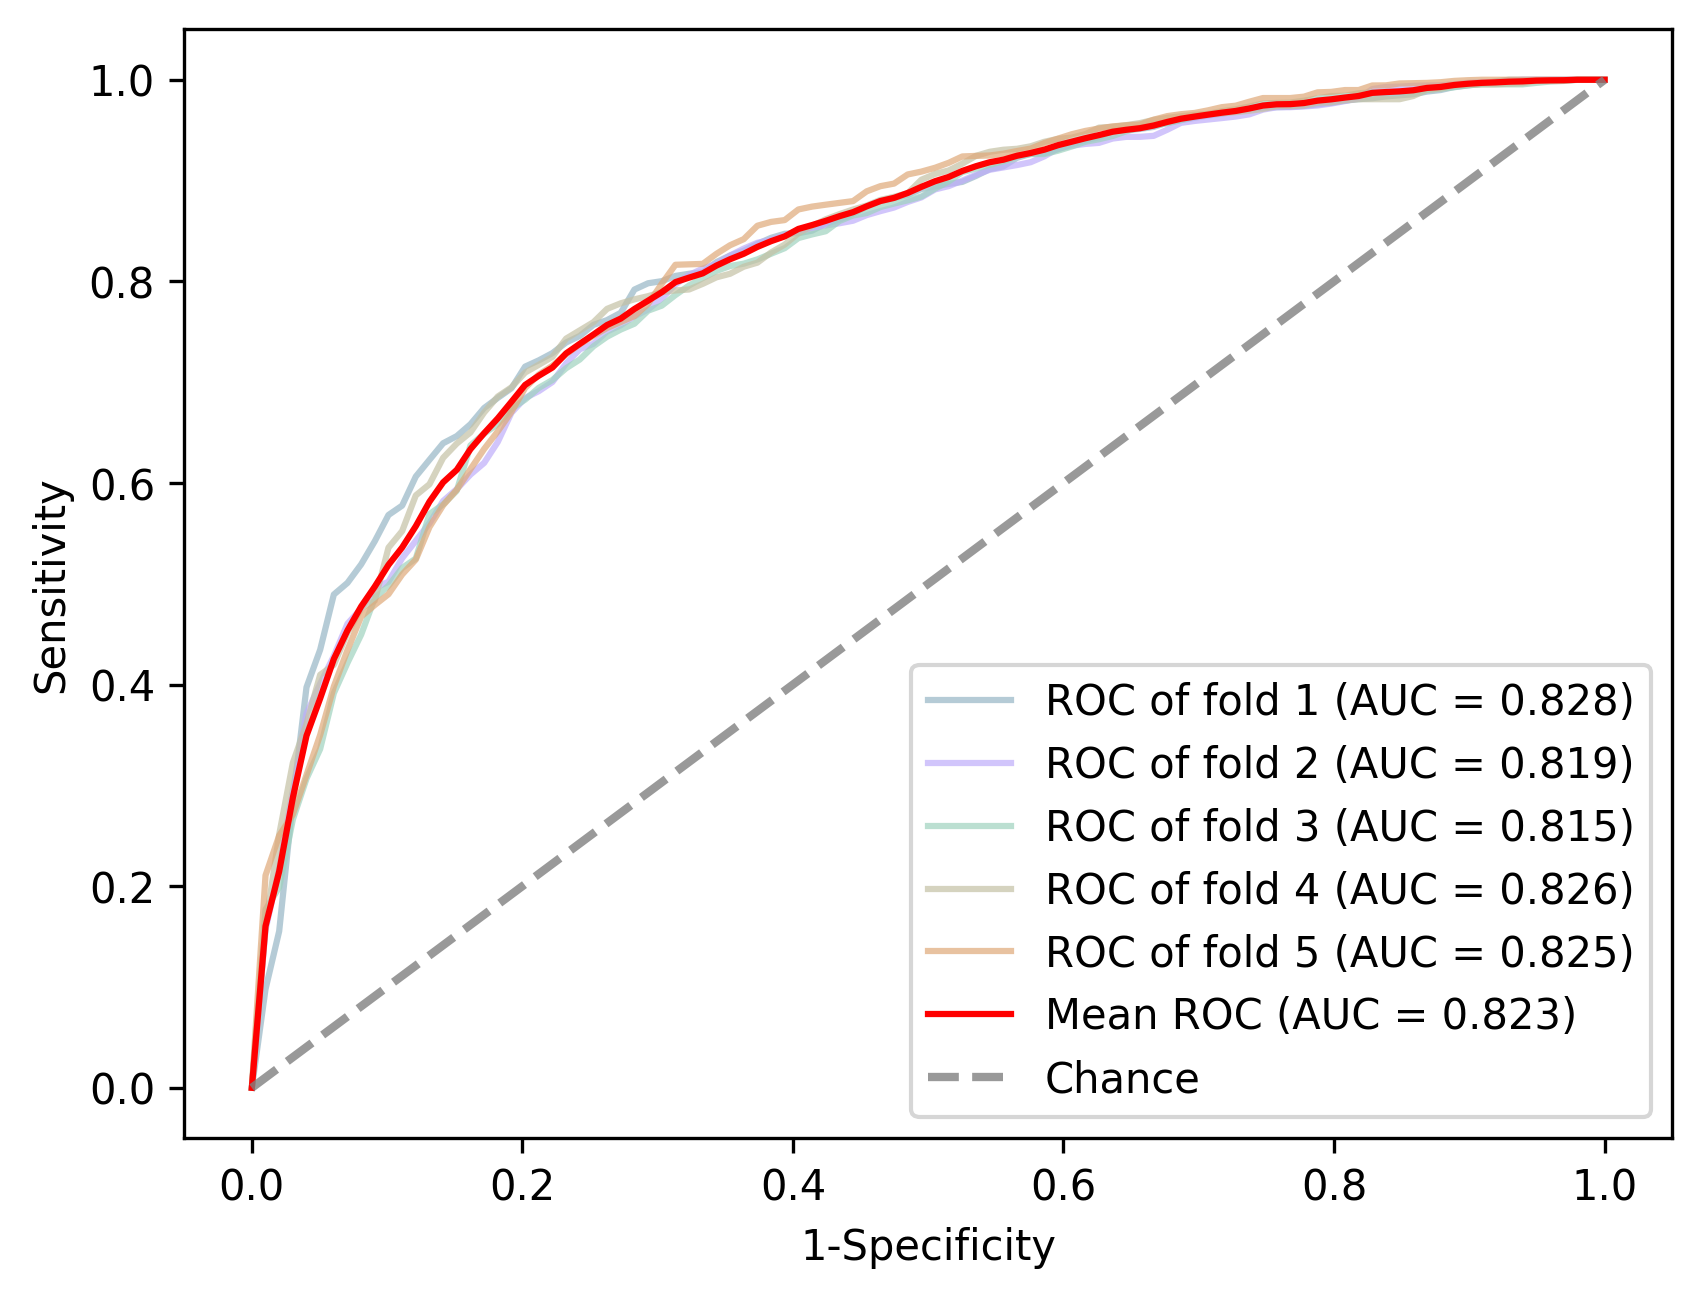

In [74]:
plt.figure(dpi=300)
plt.plot(fprs,tprs_vali[0],color='#96B6C5',alpha=0.7,label='ROC of fold 1 (AUC = {:.3f})'.format(aucs_vali[0]))
plt.plot(fprs,tprs_vali[1],color='#BEADFA',alpha=0.7,label='ROC of fold 2 (AUC = {:.3f})'.format(aucs_vali[1]))
plt.plot(fprs,tprs_vali[2],color='#9ED2BE',alpha=0.7,label='ROC of fold 3 (AUC = {:.3f})'.format(aucs_vali[2]))
plt.plot(fprs,tprs_vali[3],color='#C4C1A4',alpha=0.7,label='ROC of fold 4 (AUC = {:.3f})'.format(aucs_vali[3]))
plt.plot(fprs,tprs_vali[4],color='#DFA878',alpha=0.7,label='ROC of fold 5 (AUC = {:.3f})'.format(aucs_vali[4]))
plt.plot(fprs,np.average(tprs_vali,axis=0),color='red',label='Mean ROC (AUC = {:.3f})'.format(np.mean(aucs_vali)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',label='Chance', alpha=.8)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend()

In [94]:
test = pd.read_csv('data_test.csv')
X_test = test.iloc[:,1:-1]
y_test = test.iloc[:,-1]

X_new,y_new = ous.fit_resample(train.iloc[:,1:-1],train['type'])
model = KNeighborsClassifier(n_neighbors=166)
model.fit(X_new,y_new)

pro_test = model.predict_proba(X_test)[:,1]
fpr_test,tpr_test,th_test = roc_curve(y_test,pro_test)
auc_test = roc_auc_score(y_test,pro_test)

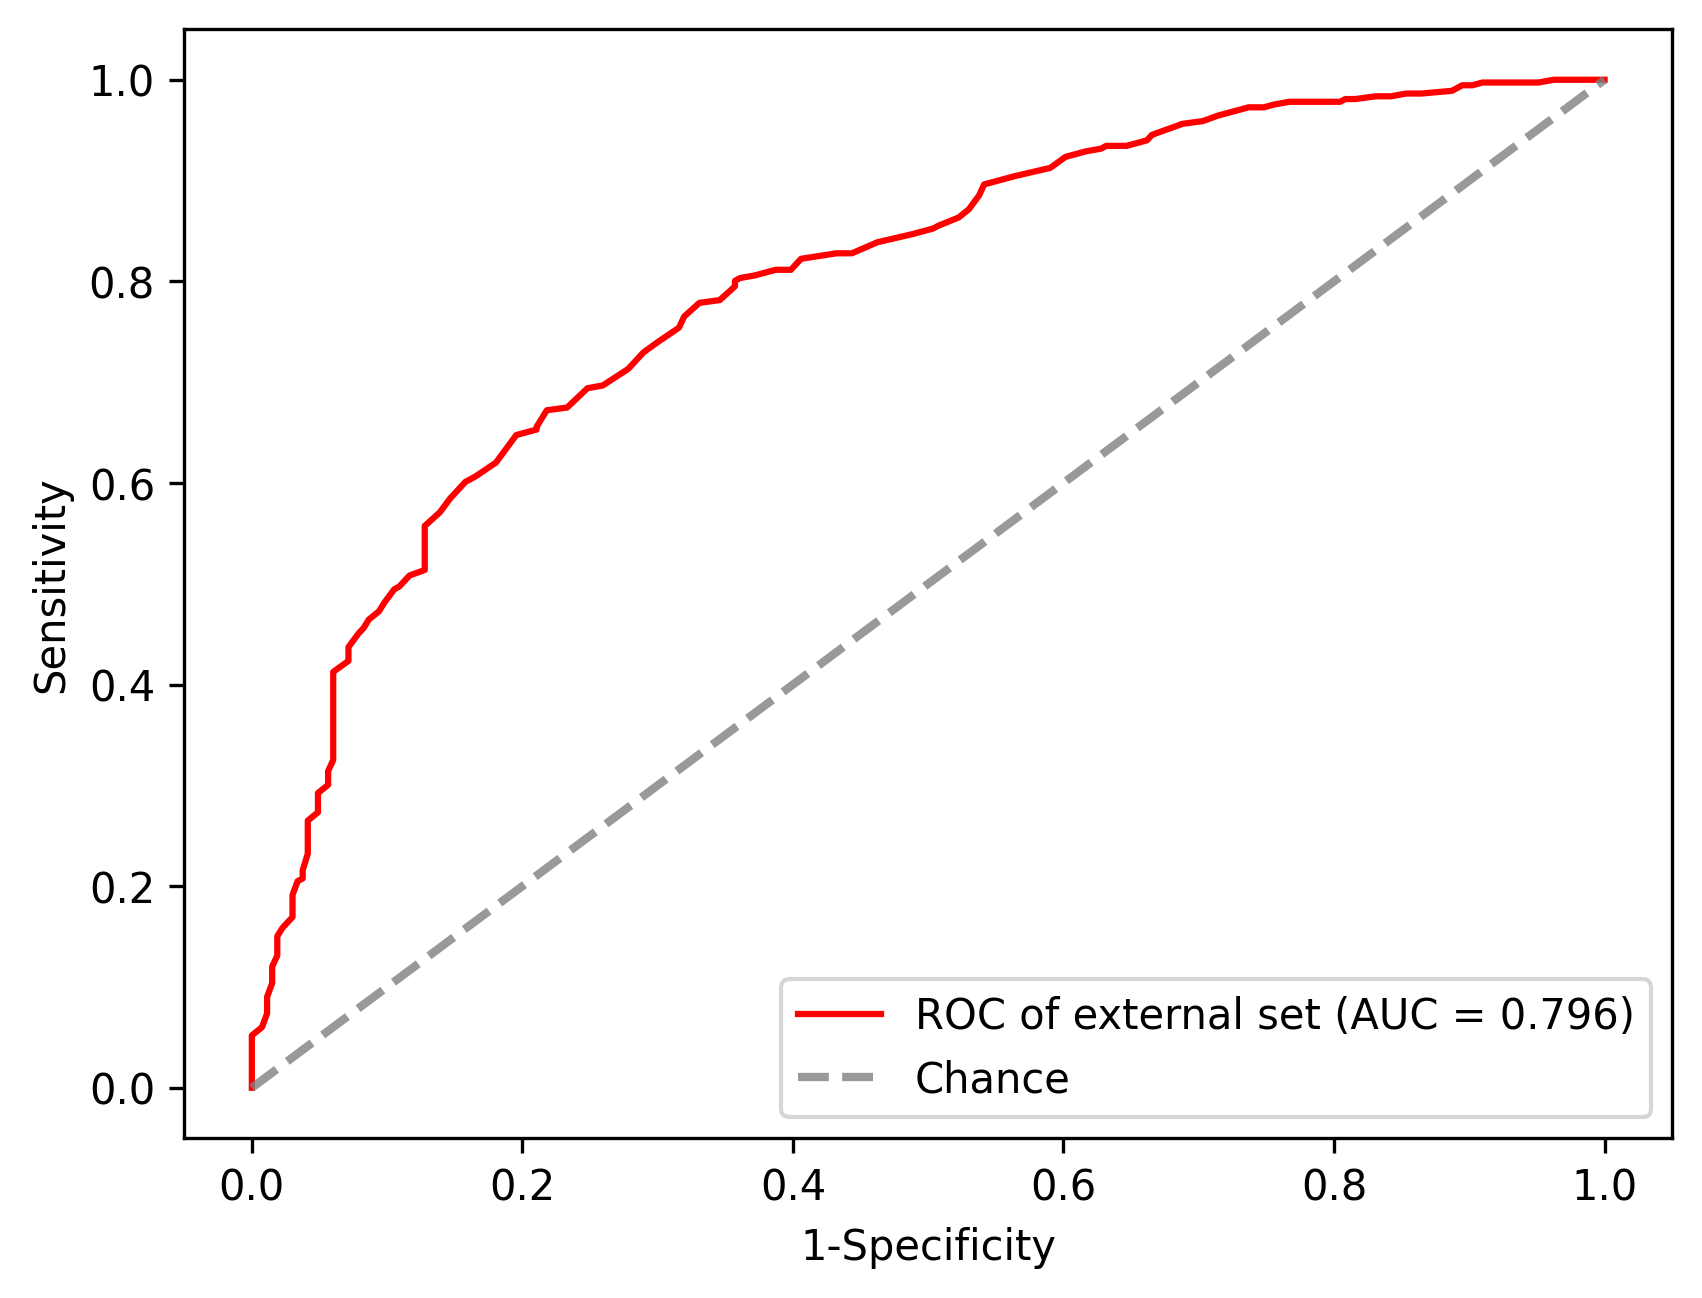

In [95]:
plt.figure(dpi=300)
plt.plot(fpr_test,tpr_test,color='red',label='ROC of external set (AUC = {:.3f})'.format(auc_test))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',label='Chance', alpha=.8)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend()

In [96]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold

In [97]:
print(Find_Optimal_Cutoff(th_tpr[0],th_fpr[0],th_th[0]))
print(Find_Optimal_Cutoff(th_tpr[1],th_fpr[1],th_th[1]))
print(Find_Optimal_Cutoff(th_tpr[2],th_fpr[2],th_th[2]))
print(Find_Optimal_Cutoff(th_tpr[3],th_fpr[3],th_th[3]))
print(Find_Optimal_Cutoff(th_tpr[4],th_fpr[4],th_th[4]))
mean_th = 0.51

0.5421686746987951
0.5240963855421686
0.5481927710843374
0.5481927710843374
0.5


In [98]:
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score

In [99]:
def NPV(Y_true,Y_pre):
    Y_true = pd.DataFrame(Y_true)
    Y_pre = pd.DataFrame(Y_pre)
    hb = pd.concat([Y_true.reset_index(drop=True),Y_pre],axis=1,ignore_index=True)
    tn = hb[(hb[0]==0) & (hb[1]==0)].shape[0]
    fn = hb[(hb[0]==1) & (hb[1]==0)].shape[0]
    return tn/(tn+fn)

In [100]:
for index,(train_index,vali_index) in enumerate(sp.split(train,train['type'])):
    data_train = train.iloc[train_index,:]
    data_vali = train.iloc[vali_index,:]
    X_train = data_train.iloc[:,1:-1]
    y_train = data_train.iloc[:,-1]
    X_vali = data_vali.iloc[:,1:-1]
    y_vali = data_vali.iloc[:,-1]
    X_train,y_train = ous.fit_resample(X_train,y_train)
    model = KNeighborsClassifier(n_neighbors=166)
    model.fit(X_train,y_train)
    pre_train = np.where(model.predict_proba(X_train)[:,1] >= mean_th,1,0)
    pre_vali = np.where(model.predict_proba(X_vali)[:,1] >= mean_th,1,0)
    acc_train = accuracy_score(y_train,pre_train)
    acc_vali = accuracy_score(y_vali,pre_vali)
    repor_train = classification_report_imbalanced(y_train,pre_train).split()
    repor_vali = classification_report_imbalanced(y_vali,pre_vali).split()
    sensitivity_train = repor_train[17]
    sensitivity_vali = repor_vali[17]
    specificity_train = repor_train[18]
    specificity_vali = repor_vali[18]
    f1_train = repor_train[19]
    f1_vali = repor_vali[19]
    ppv_train = repor_train[16]
    ppv_vali = repor_vali[16]
    npv_train = NPV(y_train,pre_train)
    npv_vali = NPV(y_vali,pre_vali)

    if index==0:
        with open('metric_KNN.txt','w') as f:
            f.write('训练集_fold {}\n'.format(index+1))
            f.write('Accuracy:{}\n'.format(acc_train))
            f.write('Sensitivity:{}\n'.format(sensitivity_train))
            f.write('Specificity:{}\n'.format(specificity_train))
            f.write('PPV:{}\n'.format(ppv_train))
            f.write('NPV:{}\n'.format(npv_train))
            f.write('F1 score:{}\n'.format(f1_train))
            f.write('\n')
            f.write('验证集_fold {}\n'.format(index+1))
            f.write('Accuracy:{}\n'.format(acc_vali))
            f.write('Sensitivity:{}\n'.format(sensitivity_vali))
            f.write('Specificity:{}\n'.format(specificity_vali))
            f.write('PPV:{}\n'.format(ppv_vali))
            f.write('NPV:{}\n'.format(npv_vali))
            f.write('F1 score:{}\n'.format(f1_vali))
            f.write('\n\n')
    else:
        with open('metric_KNN.txt','a') as f:
            f.write('训练集_fold {}\n'.format(index+1))
            f.write('Accuracy:{}\n'.format(acc_train))
            f.write('Sensitivity:{}\n'.format(sensitivity_train))
            f.write('Specificity:{}\n'.format(specificity_train))
            f.write('PPV:{}\n'.format(ppv_train))
            f.write('NPV:{}\n'.format(npv_train))
            f.write('F1 score:{}\n'.format(f1_train))
            f.write('\n')
            f.write('验证集_fold {}\n'.format(index+1))
            f.write('Accuracy:{}\n'.format(acc_vali))
            f.write('Sensitivity:{}\n'.format(sensitivity_vali))
            f.write('Specificity:{}\n'.format(specificity_vali))
            f.write('PPV:{}\n'.format(ppv_vali))
            f.write('NPV:{}\n'.format(npv_vali))
            f.write('F1 score:{}\n'.format(f1_vali))
            f.write('\n\n')

In [101]:
X_new,y_new = ous.fit_resample(train.iloc[:,1:-1],train['type'])
model = KNeighborsClassifier(n_neighbors=166)
model.fit(X_new,y_new)
pro_test = model.predict_proba(X_test)[:,1]
pre_test = np.where(pro_test>mean_th,1,0)

In [102]:
acc_test = accuracy_score(y_test,pre_test)
repor_test = classification_report_imbalanced(y_test,pre_test).split()
sensitivity_test = repor_test[17]
specificity_test = repor_test[18]
f1_test = repor_test[19]
ppv_test = repor_test[16]
npv_test = NPV(y_test,pre_test)

In [103]:
with open('metric_test.txt','w') as f:
    f.write('Accuracy:{}\n'.format(acc_test))
    f.write('Sensitivity:{}\n'.format(sensitivity_test))
    f.write('Specificity:{}\n'.format(specificity_test))
    f.write('PPV:{}\n'.format(ppv_test))
    f.write('NPV:{}\n'.format(npv_test))
    f.write('F1 score:{}\n'.format(f1_test))

In [104]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [105]:
ps_train = []
ps_vali = []
rs = np.linspace(0,1,100)
aps_train = []
aps_vali = []
for index,(train_index,vali_index) in enumerate(sp.split(train,train['type'])):
    data_train = train.iloc[train_index,:]
    data_vali = train.iloc[vali_index,:]
    X_train = data_train.iloc[:,1:-1]
    y_train = data_train.iloc[:,-1]
    X_vali = data_vali.iloc[:,1:-1]
    y_vali = data_vali.iloc[:,-1]
    X_train,y_train = ous.fit_resample(X_train,y_train)
    model = KNeighborsClassifier(n_neighbors=166)
    model.fit(X_train,y_train)
    pro_train = model.predict_proba(X_train)[:,1]
    pro_vali = model.predict_proba(X_vali)[:,1]
    p_train,r_train,th = precision_recall_curve(y_train,pro_train)
    p_vali,r_vali,th_vali = precision_recall_curve(y_vali,pro_vali)
    ap_train = average_precision_score(y_train,pro_train)
    ap_vali = average_precision_score(y_vali,pro_vali)
    ps_train.append(np.interp(rs,p_train,r_train))
    ps_vali.append(np.interp(rs,p_vali,r_vali))
    aps_train.append(ap_train)
    aps_vali.append(ap_vali)

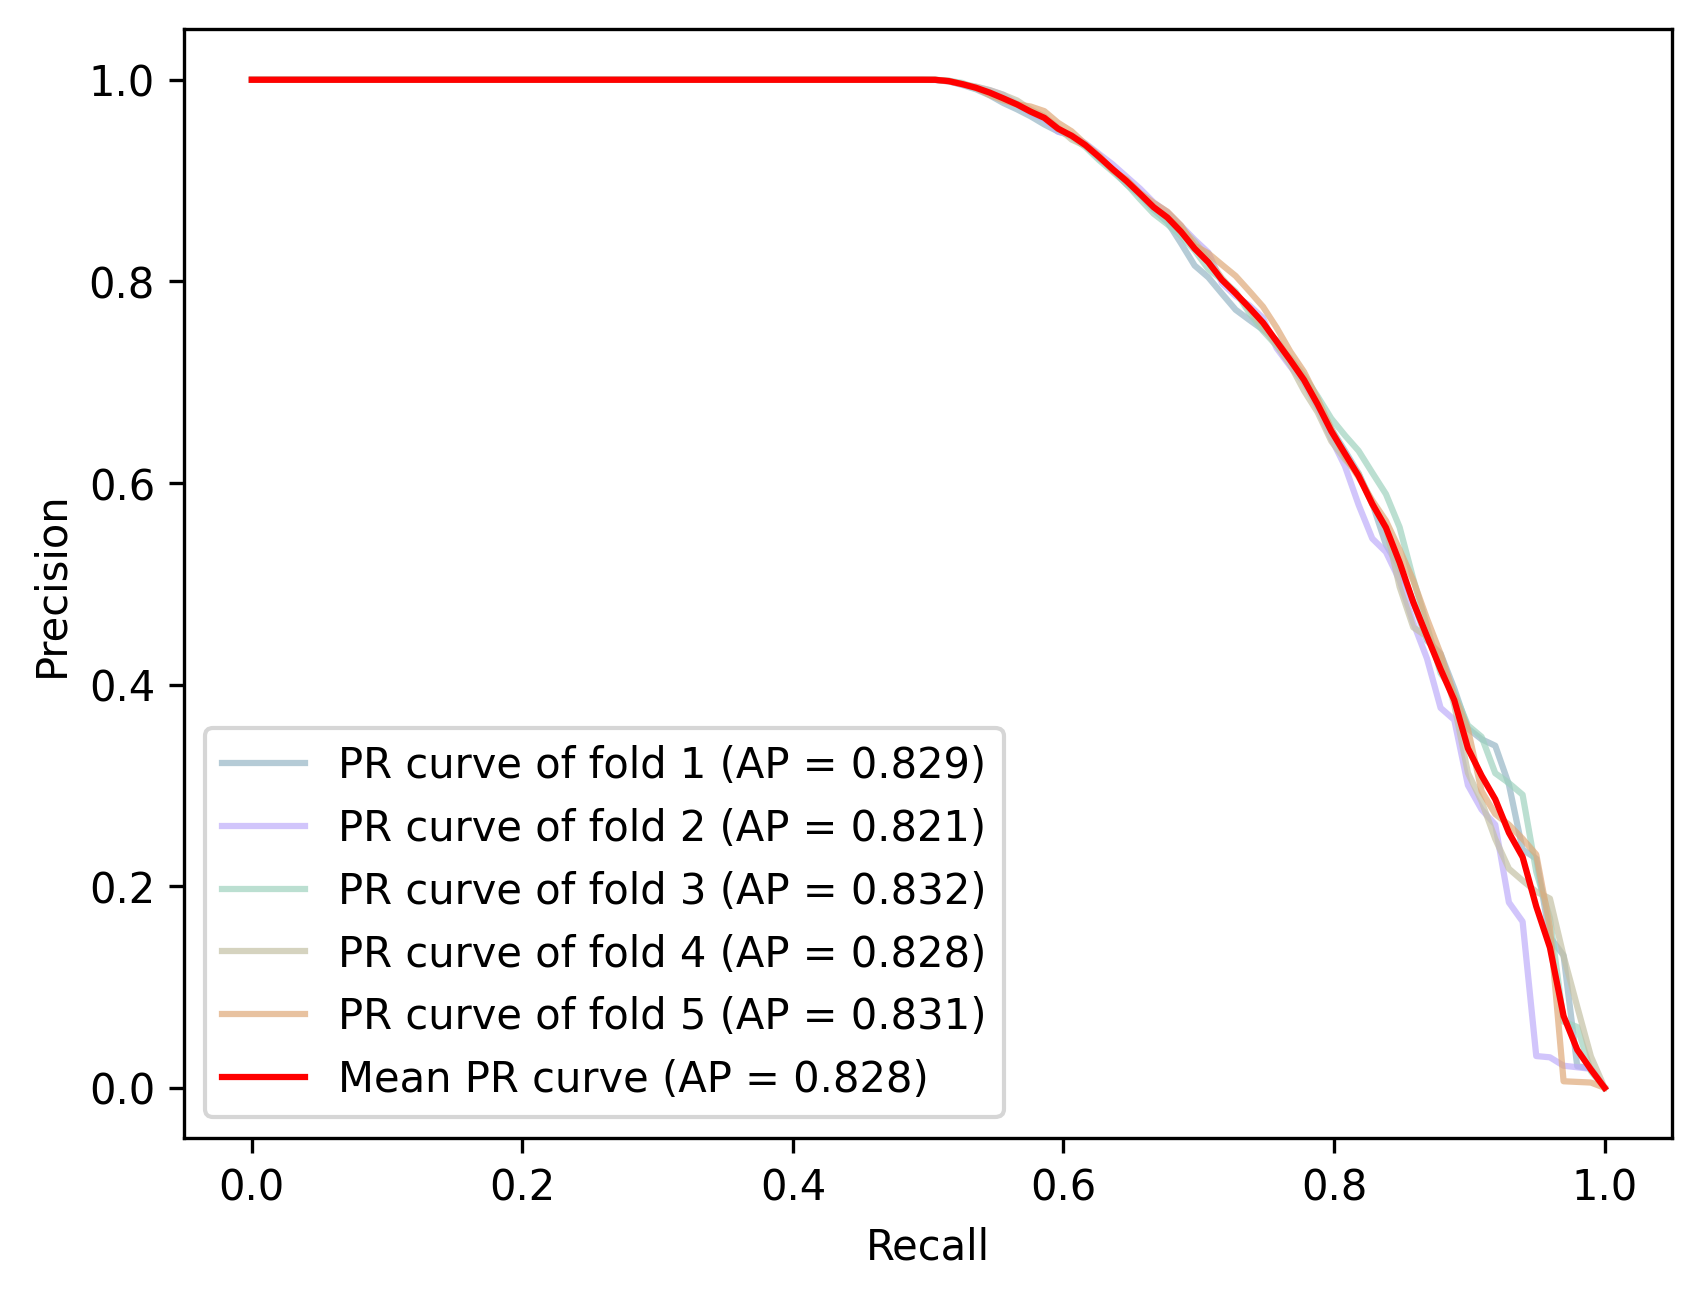

In [106]:
plt.figure(dpi=300)
plt.plot(rs,ps_train[0],color='#96B6C5',alpha=0.7,label='PR curve of fold 1 (AP = {:.3f})'.format(aps_train[0]))
plt.plot(rs,ps_train[1],color='#BEADFA',alpha=0.7,label='PR curve of fold 2 (AP = {:.3f})'.format(aps_train[1]))
plt.plot(rs,ps_train[2],color='#9ED2BE',alpha=0.7,label='PR curve of fold 3 (AP = {:.3f})'.format(aps_train[2]))
plt.plot(rs,ps_train[3],color='#C4C1A4',alpha=0.7,label='PR curve of fold 4 (AP = {:.3f})'.format(aps_train[3]))
plt.plot(rs,ps_train[4],color='#DFA878',alpha=0.7,label='PR curve of fold 5 (AP = {:.3f})'.format(aps_train[4]))
plt.plot(rs,np.average(ps_train,axis=0),color='red',label='Mean PR curve (AP = {:.3f})'.format(np.mean(aps_train)))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()

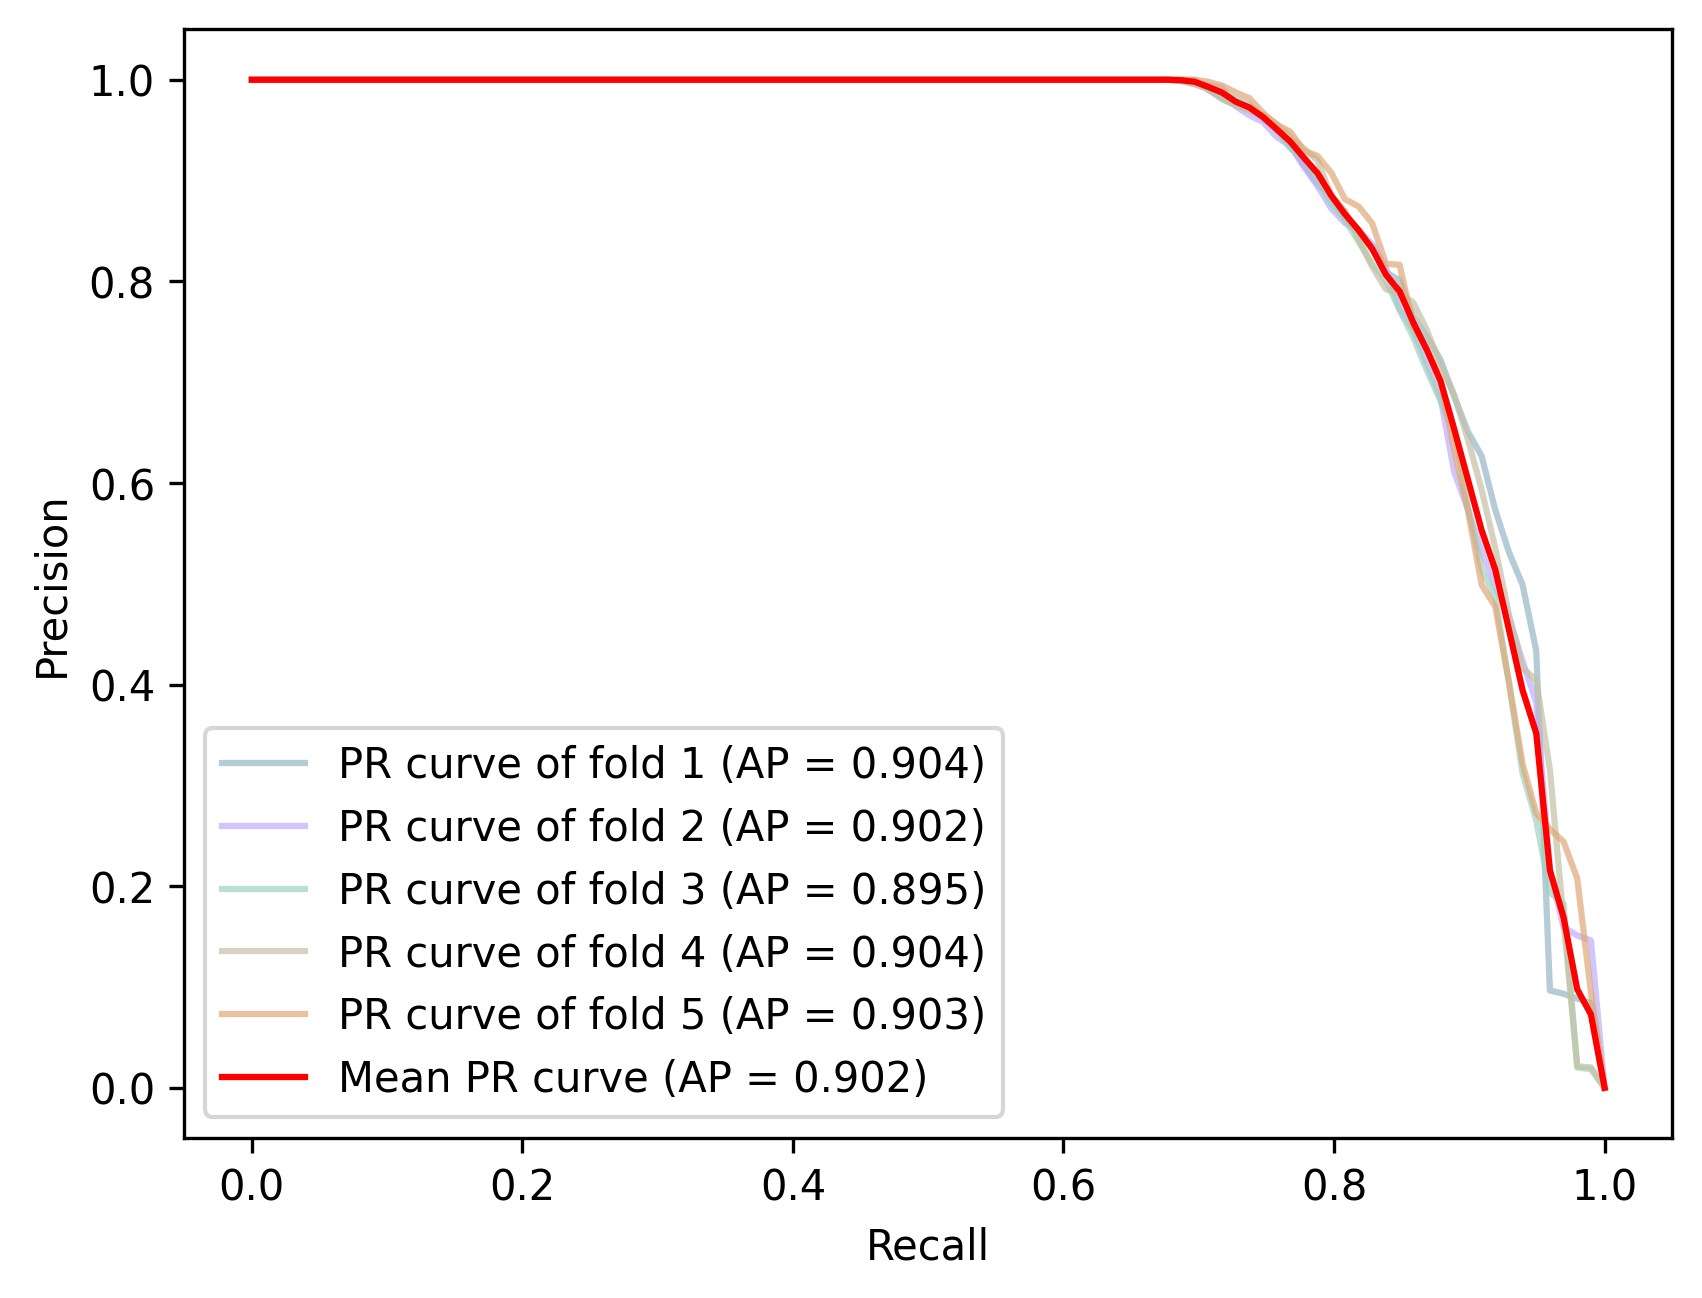

In [107]:
plt.figure(dpi=300)
plt.plot(rs,ps_vali[0],color='#96B6C5',alpha=0.7,label='PR curve of fold 1 (AP = {:.3f})'.format(aps_vali[0]))
plt.plot(rs,ps_vali[1],color='#BEADFA',alpha=0.7,label='PR curve of fold 2 (AP = {:.3f})'.format(aps_vali[1]))
plt.plot(rs,ps_vali[2],color='#9ED2BE',alpha=0.7,label='PR curve of fold 3 (AP = {:.3f})'.format(aps_vali[2]))
plt.plot(rs,ps_vali[3],color='#C4C1A4',alpha=0.7,label='PR curve of fold 4 (AP = {:.3f})'.format(aps_vali[3]))
plt.plot(rs,ps_vali[4],color='#DFA878',alpha=0.7,label='PR curve of fold 5 (AP = {:.3f})'.format(aps_vali[4]))
plt.plot(rs,np.average(ps_vali,axis=0),color='red',label='Mean PR curve (AP = {:.3f})'.format(np.mean(aps_vali)))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()

In [108]:
X_new,y_new = ous.fit_resample(train.iloc[:,1:-1],train['type'])
model = KNeighborsClassifier(n_neighbors=166)
model.fit(X_new,y_new)
pro_test = model.predict_proba(X_test)[:,1]
pre_test = np.where(pro_test>mean_th,1,0)
p_test,r_test,th = precision_recall_curve(y_test,pro_test)
ap_test = average_precision_score(y_test,pro_test)

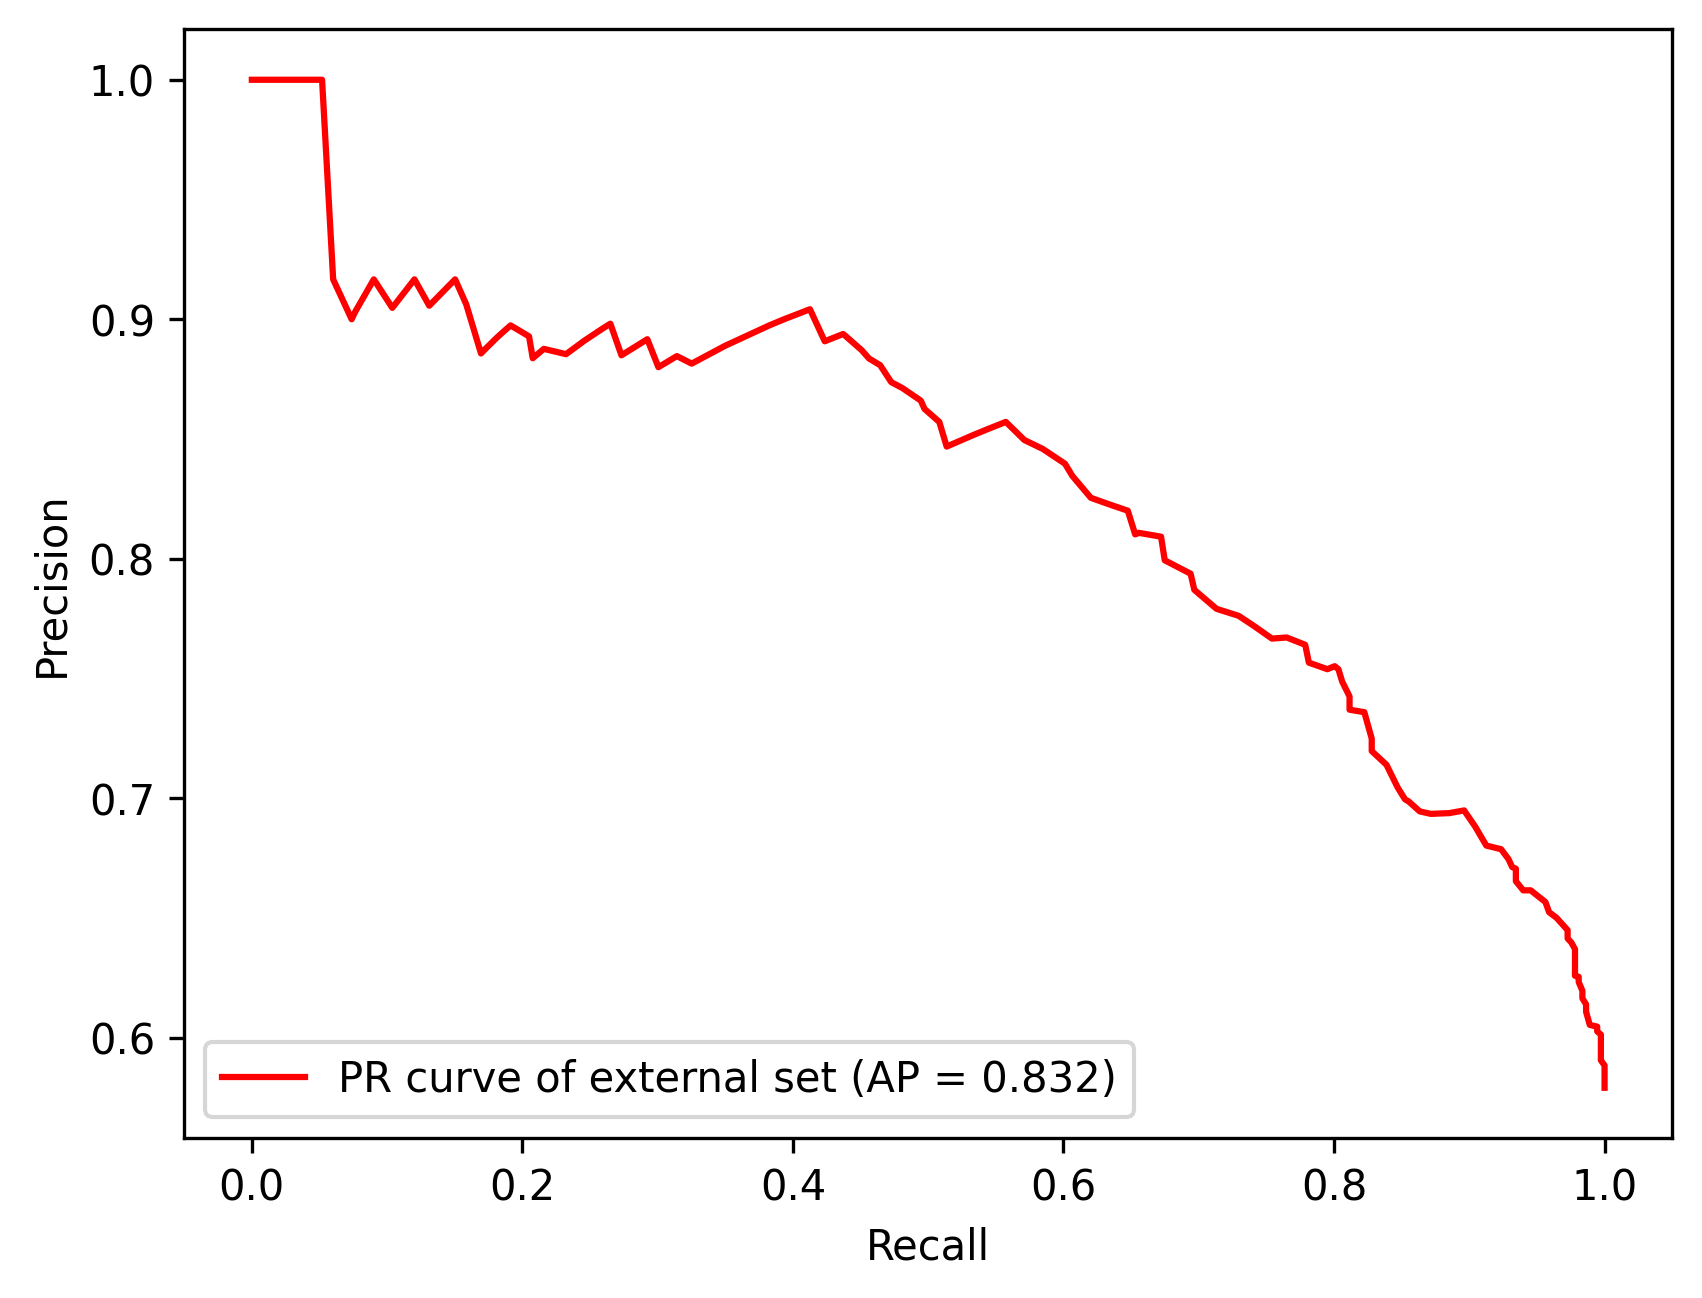

In [109]:
plt.figure(dpi=300)
plt.plot(r_test,p_test,color='red',label='PR curve of external set (AP = {:.3f})'.format(ap_test))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc=3)